# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fix bug

***Please run this cell first***

If numpy version > 1.26.4, run the cell below and restart the session (Runtime → Restart runtime)

In [1]:
import numpy as np
print(np.__version__)

1.26.4


In [5]:
# After executing this cell, you must Restart runtime (Runtime → Restart runtime)
import sys
import subprocess
import numpy as np

# !pip install numpy==1.26.4
def check_and_install_numpy(required_ver="1.26.4"):
  current_ver = np.__version__

  if current_ver != required_ver:
    print(f"Installing numpy=={required_ver}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", f"numpy=={required_ver}"])
    print("Numpy has been updated. Please restart your runtime for changes to take effect.")
  else:
    print("Numpy version is already correct.")

check_and_install_numpy()

Installing numpy==1.26.4...
Numpy has been updated. Please restart your runtime for changes to take effect.


# Installations

In [2]:
!pip install pyvi
!pip install torch
!pip install gensim
# !pip install underthesea
!pip install transformers

# Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from pyvi import ViTokenizer

import gensim
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import torch

import joblib

from transformers import AutoTokenizer, AutoModel, TFAutoModel

# Dataset paths

In [4]:
train_path = '/content/drive/MyDrive/Dataset/NLP/train.csv'
test_path = '/content/drive/MyDrive/Dataset/NLP/test.csv'
stopwords_path = '/content/drive/MyDrive/Dataset/NLP/stopwords-vi.txt'

# Preprocess dataset

In [5]:
def load_stopwords(file_path):
  with open(file_path, 'r', encoding='utf-8-sig') as f:
    return {line.strip() for line in f if line.strip()}

def preprocess(text, stopwords):
  tokenized_text = ViTokenizer.tokenize(text)
  tokens = simple_preprocess(tokenized_text)
  tokens = [token for token in tokens if token not in stopwords]
  return " ".join(tokens)

def preprocess_bert(text, stopwords):
  tokens = simple_preprocess(text)
  tokens = [token for token in tokens if token not in stopwords]
  return " ".join(tokens)

Load Vietnamese stopwords

In [6]:
stopwords = load_stopwords(stopwords_path)

In [ ]:
# load Vietnamese stopwords
stopwords = load_stopwords(stopwords_path)

# preprocess train dataset and save as 'processed_train.csv'
train_df = pd.read_csv(train_path)
train_df['text'] = train_df['text'].apply(lambda x: preprocess(x, stopwords))
train_df.to_csv('processed_train.csv')

# preprocess test dataset and save as 'processed_test.csv'
test_df = pd.read_csv(test_path)
test_df['text'] = test_df['text'].apply(lambda x: preprocess(x, stopwords))
test_df.to_csv('processed_test.csv')

In [ ]:
train_df = pd.read_csv(train_path)
train_df['text'] = train_df['text'].apply(lambda x: preprocess_bert(x, stopwords))
train_df.to_csv('bert_processed_train.csv')

test_df = pd.read_csv(test_path)
test_df['text'] = test_df['text'].apply(lambda x: preprocess_bert(x, stopwords))
test_df.to_csv('bert_processed_test.csv')

In [7]:
train_path = '/content/drive/MyDrive/Dataset/NLP/processed_train.csv'
test_path = '/content/drive/MyDrive/Dataset/NLP/processed_test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.shape, test_df.shape

((33759, 3), (50373, 3))

In [9]:
train_df['text'].iloc[10]

'phòng học bộ_môn xóa_bỏ tình_trạng dạy chay học chạy học_sinh cơ_hội thực_hành phòng học bộ_môn phòng học truyền_thống bảng_đen phấn trắng bàn ghế học_sinh thụ_động giờ học giáo_viên bộ_môn di_chuyển thời khóa biểu giáo_viên tự mang thiết_bị dạy_học lớp nội_dung giảng cần_thiết_bị cách dạy phù_hợp kiểu dạy chay học chay tất_cả vấn_đề khắc_phục phòng học bộ_môn lê_quán tần vụ_trưởng vụ giáo_dục trung_học khẳng_định xóa_sổ phòng học truyền_thống giáo_dục đào_tạo hoàn_thiện sửa_đổi bổ_sung quy_chế phòng học bộ_môn phbm trường trung_học bao_gồm trường thcs thpt đạt chuẩn quốc_gia cụ_thể trường đạt chuẩn xây_dựng phbm dành môn_học như_vậy tiết học thay_vì ngồi học lý_thuyết đơn_thuần học_sinh chuyển sang học phòng tài_liệu thiết_bị đặc_thù giúp học_sinh thực_hiện hoạt_động thực_hành môn_học lê hoàng_hảo giám_đốc công_ty thiết_bị giáo_dục phbm xu_hướng tất_yếu nước giáo_dục tiên_tiến học_sinh học lý_thuyết thực_hành phbm phòng học kiểu thiết_bị bảo_quản tốt di_chuyển tiết_kiệm kinh_tế thiết

Get texts, labels

In [10]:
X_train = train_df['text']
y_train = train_df['label']

X_test = test_df['text']
y_test = test_df['label']

Distribution chart of train labels

<Axes: xlabel='label'>

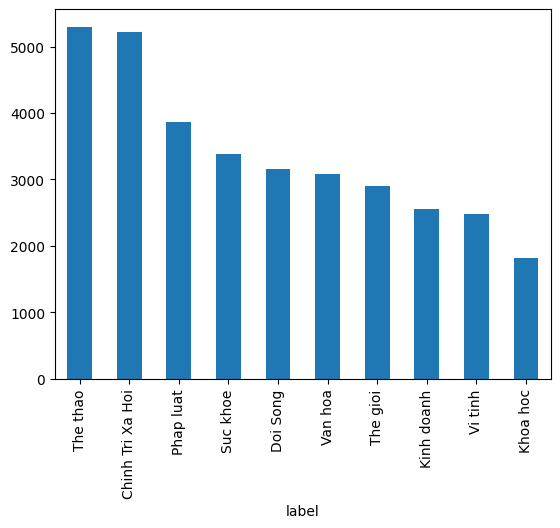

In [12]:
y_train.value_counts().plot(kind='bar')

In [13]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

y_train, y_test

(array([0, 0, 0, ..., 9, 9, 9]), array([0, 0, 0, ..., 9, 9, 9]))

# Bag of Words

## Define training ML model method

In [ ]:
def classification_pipeline(X_train, X_test, y_train, y_test):
  accuracies = {}
  classifiers = {
      "Logistic Regression": LogisticRegression(),
      "Naive Bayes": MultinomialNB(),
      "Decision Tree": DecisionTreeClassifier()
  }

  for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")
    accuracies[name] = acc

  return accuracies

def plot_accuracies(accuracies):
  models = list(accuracies.keys())
  acc_values = list(accuracies.values())

  plt.figure(figsize=(8, 6))
  bars = plt.bar(models, acc_values, width=0.4, color='skyblue', edgecolor='black')
  plt.xlabel('Models')
  plt.ylabel('Accuracy')
  plt.title('Model Accuracies')
  plt.ylim(0, 1)
  plt.grid(False)

  for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
      f"{bar.get_height():.4f}", ha='center', va='bottom')

  plt.show()

## Count Vectors as features

In [ ]:
# def sparse_to_dense(sparse):
#   try:
#     return sparse.toarray()
#   except MemoryError:
#     print("Not enough memory to convert from sparse matrix to dense matrix")
#     return None

In [ ]:
count_vectorizer = CountVectorizer(max_features=5000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [ ]:
X_train_count[0].toarray()

Logistic Regression Accuracy: 0.9046
Naive Bayes Accuracy: 0.8885
Decision Tree Accuracy: 0.7261


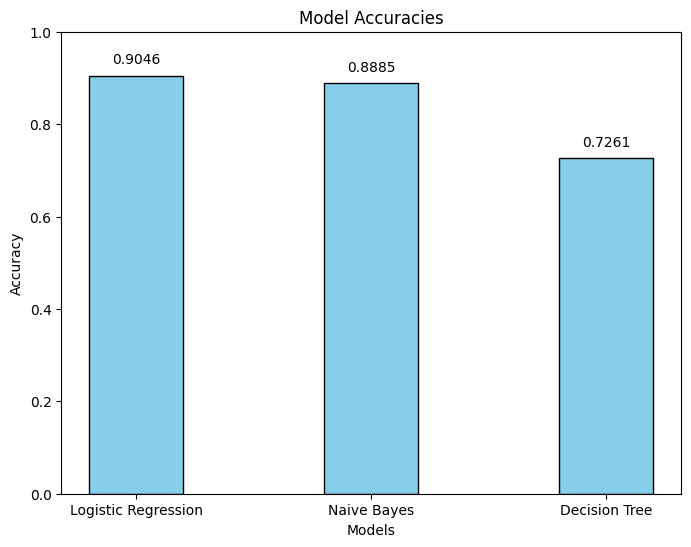

In [ ]:
accuracies = classification_pipeline(X_train_count, X_test_count, y_train, y_test)
plot_accuracies(accuracies)

## TF-IDF Vectors as features

In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
X_train_tfidf[0].toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.09802604,
        0.        ]])

Logistic Regression Accuracy: 0.9215
Naive Bayes Accuracy: 0.8902
Decision Tree Accuracy: 0.7205


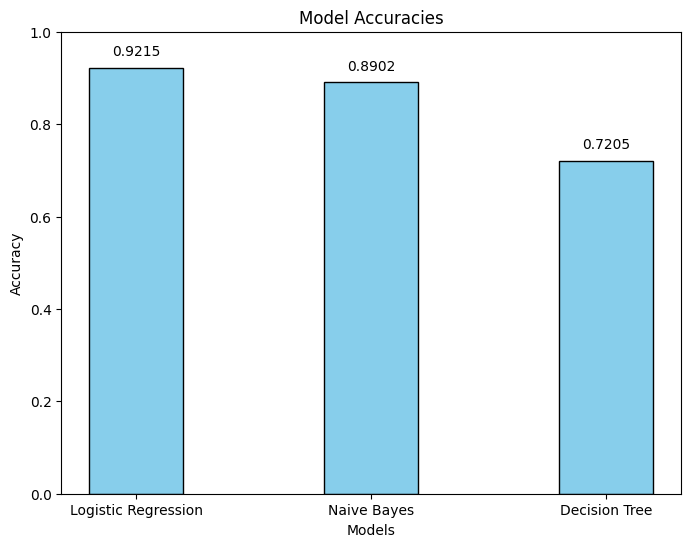

In [ ]:
accuracies = classification_pipeline(X_train_tfidf, X_test_tfidf, y_train, y_test)
plot_accuracies(accuracies)

# Doc2Vec

In [ ]:
def train_nn_model(X_train, y_train, X_test, y_test, epochs=30, embedding_dim=300):
  num_classes = len(np.unique(y_train))
  y_train_cat = to_categorical(y_train, num_classes=num_classes)
  y_test_cat = to_categorical(y_test, num_classes=num_classes)

  model = Sequential()
  model.add(Input(shape=(embedding_dim,)))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(optimizer=Adam(learning_rate=0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  model.summary()

  history = model.fit(X_train, y_train_cat, epochs=epochs, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1)
  loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
  print(f"\nTest Accuracy: {accuracy:.4f}")
  model.save('nn_model.keras')

  return model, history

In [43]:
def train_nn_model(X_train, y_train, X_test, y_test, epochs=30, embedding_dim=300):
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes=num_classes)
    y_test_cat = to_categorical(y_test, num_classes=num_classes)

    # Define the model
    model = Sequential()
    model.add(Input(shape=(embedding_dim,)))

    # Add layers with L2 regularization

    # Dense layer 1
    model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())

    # Dense layer 2
    model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Dense layer 3
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(0.4))
    model.add(BatchNormalization())

    # Dense layer 4
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
    model.add(Dropout(0.3))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model with early stopping
    history = model.fit(X_train, y_train_cat, epochs=epochs, batch_size=32,
                        validation_data=(X_test, y_test_cat), verbose=1,
                        callbacks=[early_stopping])

    loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"\nAccuracy: {accuracy:.4f}")

    model.save('nn_model.keras')

    return model, history

In [15]:
def plot_history(history):
  epochs = range(1, len(history.history['loss']) + 1)

  # loss
  plt.plot(epochs, history.history['loss'], 'bo-', label='Train Loss')
  plt.plot(epochs, history.history['val_loss'], 'ro-', label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  # accuracy
  plt.plot(epochs, history.history['accuracy'], 'bo-', label='Train Accuracy')
  plt.plot(epochs, history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

## Pretrain Model: Bert (Multilingual)

In [ ]:
# Bert Multilingual
model_name = "bert-base-multilingual-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
import tensorflow as tf
import torch.nn as nn

class ProjectionModel(nn.Module):
    def __init__(self, input_dim=768, output_dim=256):
        super(ProjectionModel, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        return self.activation(self.fc(x))

proj_model = ProjectionModel(input_dim=768, output_dim=128)
proj_model.to(device)
proj_model.eval()

ProjectionModel(
  (fc): Linear(in_features=768, out_features=128, bias=True)
  (activation): ReLU()
)

In [ ]:
def get_bert_embeddings(texts, tokenizer, bert_model, proj_model, batch_size=32, max_length=128, device=device):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenize batch of texts
        encodings = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")
        encodings = {k: v.to(device) for k, v in encodings.items()}

        with torch.no_grad():
            # Lấy output của mBERT
            outputs = bert_model(**encodings)
            # Lấy vector [CLS] (token đầu tiên) có shape (batch_size, 768)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            # Dự đoán qua Projection module để giảm chiều xuống 256
            proj_embeddings = proj_model(cls_embeddings)
        all_embeddings.append(proj_embeddings.cpu().numpy())
        print(f"Processed batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1}")

    return np.concatenate(all_embeddings, axis=0)

In [ ]:
sub = X_train.iloc[:10]
train_texts = sub.tolist()
bert_train_embeddings = get_bert_embeddings(train_texts, bert_tokenizer, bert_model, proj_model, batch_size=32, max_length=128, device=device)

Processed batch 1/1


In [ ]:
bert_train_embeddings.shape

(10, 128)

In [ ]:
train = X_train.tolist()
# test = X_test.tolist()
train_bert_embeddings = get_bert_embeddings_batch(texts=train, tokenizer=bert_tokenizer, model=bert_model)
np.save("/content/drive/MyDrive/Dataset/NLP/Model/Bert/train_bert_embeddings.npy", train_bert_embeddings)


# test_bert_embeddings = get_bert_embeddings(texts=test, tokenizer=bert_tokenizer, model=bert_model)
# np.save("/content/drive/MyDrive/Dataset/NLP/Model/Bert/test_bert_embeddings.npy", test_bert_embeddings)

Processed batch 1/1055
Processed batch 2/1055
Processed batch 3/1055
Processed batch 4/1055
Processed batch 5/1055
Processed batch 6/1055
Processed batch 7/1055
Processed batch 8/1055
Processed batch 9/1055
Processed batch 10/1055
Processed batch 11/1055
Processed batch 12/1055
Processed batch 13/1055
Processed batch 14/1055
Processed batch 15/1055
Processed batch 16/1055
Processed batch 17/1055
Processed batch 18/1055
Processed batch 19/1055
Processed batch 20/1055
Processed batch 21/1055
Processed batch 22/1055
Processed batch 23/1055
Processed batch 24/1055
Processed batch 25/1055
Processed batch 26/1055
Processed batch 27/1055
Processed batch 28/1055
Processed batch 29/1055
Processed batch 30/1055
Processed batch 31/1055
Processed batch 32/1055
Processed batch 33/1055
Processed batch 34/1055
Processed batch 35/1055
Processed batch 36/1055
Processed batch 37/1055
Processed batch 38/1055
Processed batch 39/1055
Processed batch 40/1055
Processed batch 41/1055
Processed batch 42/1055
P

KeyboardInterrupt: 

In [ ]:
train_bert_embeddings.shape

(100, 768)

In [ ]:
sample_text = "NHÓM: là nhóm sinh viên đăng ký môn học theo thời khóa biểu. Sinh viên phải xem đúng môn thi và nhóm thi để dự thi đúng ngày thi và giờ thi. Mọi trường hợp dự thi sai nhóm sẽ không được giải quyết."
train_test = X_train.tolist()
# processed_text = preprocess_bert(X_train[0], stopwords)
embedding = get_bert_embedding(X_train[0], bert_tokenizer, bert_model)

In [ ]:
print(X_train[0])
print(embedding)

thành lập dự án policy phòng chống hiv aids vn nlđ quỹ hỗ trợ khẩn cấp aids hoa kỳ thành lập dự án policy vn cam kết hỗ trợ phủ nhân dân vn đối phó hiv aids dự án nhiệm vụ cải thiện công tác phòng chống hiv aids thông lĩnh vực xây dựng sách rà soát văn pháp luật xây dựng chiến lược quảng bá xây dựng chương trình đào tạo phòng chống hiv aids kế hoạch bố trí nguồn lực huấn luyện nghiên cứu phương tiện truyền thông đại chúng tổ chức hoạt động nhằm giảm kỳ thị phân biệt đối xử đối hiv aids ttxvn dự án policy đặc biệt quan tâm công tác truyền thông phòng chống hiv aids coi biện pháp tích cực hữu hiệu phòng chống hiệu hiv aids thời gian dự án policy tiếp tục tổ chức hoạt động nhằm nâng thức trách nhiệm công tác đạo phòng chống hiv aids
[-1.25772327e-01 -1.41267791e-01  1.78397004e-03 -6.47561103e-02
 -5.43583184e-02  3.54337990e-01 -6.14441782e-02 -6.63312003e-02
 -1.69717118e-01  1.81858450e-01 -1.89566329e-01  1.10385746e-01
  1.55342117e-01  4.01996166e-01 -7.60269821e-01 -2.97096488e-03


## Pretrain Model: PhoBert (for Vietnamese)

In [ ]:
# def get_pretrain_embedding(text, tokenizer, model):
#   inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
#   outputs = model(**inputs)
#   embedding = torch.mean(outputs.last_hidden_state, dim=1).detach().numpy()
#   return embedding[0]

# def get_pretrain_embeddings(texts, tokenizer, model):
#   embeddings = []
#   for text in texts:
#     emb = get_pretrain_embedding(text, tokenizer, model)
#     embeddings.append(emb)
#   return np.array(embeddings)

In [ ]:
pho_bert = "vinai/phobert-base"
pho_bert_tokenizer = AutoTokenizer.from_pretrained(pho_bert)
pho_bert_model = AutoModel.from_pretrained(pho_bert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

## Non-pretrain Model

In [16]:
def train_doc2vec_model(texts, vector_size=300, window=5, min_count=2, epochs=10):
  documents = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(texts)]
  model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, epochs=1, compute_loss=True)
  model.build_vocab(documents)
  model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

  for epoch in range(epochs):
    model.train(documents, total_examples=model.corpus_count, epochs= 1)
    print(f"Epoch {epoch+1} / {epochs}")
  model.save("doc2vec.model")
  return model

In [17]:
def get_doc2vec_embeddings(doc2vec_model, texts):
  embeddings = []
  for text in texts:
    emb = doc2vec_model.infer_vector(text.split())
    embeddings.append(emb)
  return np.array(embeddings)

In [ ]:
doc2vec_model = train_doc2vec_model(X_train, epochs=5)

Epoch 1 / 5


Epoch 2 / 5


Epoch 3 / 5


Epoch 4 / 5
Epoch 5 / 5


In [34]:
doc2vec_model = Doc2Vec.load('/content/drive/MyDrive/Dataset/NLP/Model/Doc2Vec/doc2vec.model')

In [18]:
# X_train_doc2vec = get_doc2vec_embeddings(doc2vec_model, X_train)
# np.save("train_doc2vec_embeddings.npy", X_train_doc2vec)

# X_test_doc2vec = get_doc2vec_embeddings(doc2vec_model, X_test)
# np.save("test_doc2vec_embeddings.npy", X_test_doc2vec)

X_train_doc2vec = np.load('/content/drive/MyDrive/Dataset/NLP/Model/Doc2Vec/Embedded Data/train_doc2vec_embeddings.npy')
X_test_doc2vec = np.load('/content/drive/MyDrive/Dataset/NLP/Model/Doc2Vec/Embedded Data/test_doc2vec_embeddings.npy')

In [24]:
len(X_train_doc2vec), len(X_test_doc2vec)

(33759, 50373)

In [44]:
#0.8486
nn_model, history = train_nn_model(X_train_doc2vec, y_train, X_test_doc2vec, y_test)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         154,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,826 (1.26 MB)

 Trainable params: 329,034 (1.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.1556 - loss: 7.4246 - val_accuracy: 0.5799 - val_loss: 5.7907
Epoch 2/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.3969 - loss: 5.9016 - val_accuracy: 0.7058 - val_loss: 4.7405
Epoch 3/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - accuracy: 0.5558 - loss: 4.8810 - val_accuracy: 0.7687 - val_loss: 3.8852
Epoch 4/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 16s 16ms/step - accuracy: 0.6399 - loss: 4.0776 - val_accuracy: 0.7965 - val_loss: 3.2290
Epoch 5/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6870 - loss: 3.4160 - val_accuracy: 0.8065 - val_loss: 2.7039
Epoch 6/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.7160 - loss: 2.8700 - val_accuracy: 0.8145 - val_loss: 2.2740
Epoch 7/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7417 - loss: 2.4283 - val_accuracy: 0.8174 - val_loss: 1.9429
Epoch 8/30
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.7567 -

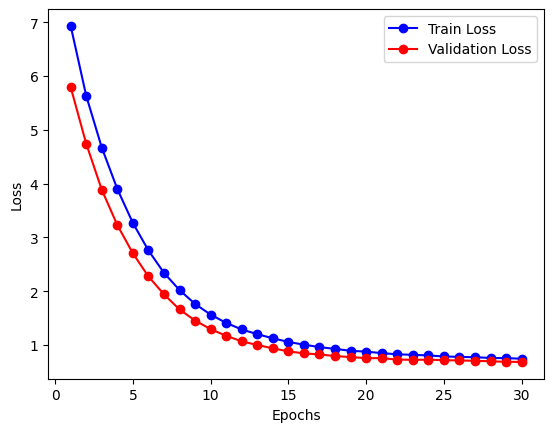

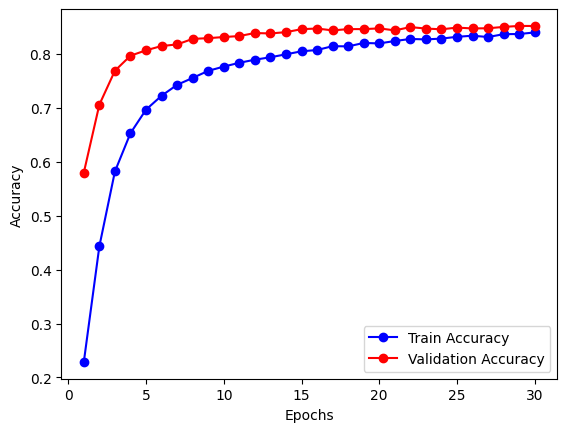

In [45]:
plot_history(history)

In [46]:
from tensorflow.keras.models import load_model

nn_model = load_model("nn_model.keras")
nn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │         154,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 988,896 (3.77 MB)

 Trainable params: 329,034 (1.26 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 658,070 (2.51 MB)

In [47]:
def classify_text(text, stopwords, doc2vec, model):
  text = preprocess(text, stopwords)
  vector = doc2vec.infer_vector(text.split())
  vector = np.array(vector).reshape(1, -1)

  pred = model.predict(vector)
  pred_idx = np.argmax(pred, axis=1)[0]

  labels = ['Chính trị xã hội', 'Đời sống', 'Khoa học', 'Kinh doanh', 'Pháp luật', 'Sức khoẻ', 'Thế giới', 'Thể thao', 'Văn hoá', 'Vi tính']
  pred_label = labels[pred_idx]
  print("Predicted class index:", pred_idx)
  print("Predicted class label:", pred_label)

In [50]:
text = """Tàu vũ trụ của SpaceX kết nối ISS
Tàu vũ trụ Crew Dragon của công ty hàng không vũ trụ SpaceX đã kết nối thành công với Trạm Vũ trụ quốc tế (ISS) vào rạng sáng 16/3 (theo giờ Mỹ), đưa 4 phi hành gia mới lên trạm trong sứ mệnh thay thế 2 phi hành gia của Cơ quan Hàng không và Vũ trụ Mỹ (NASA) bị mắc kẹt tại ISS trong suốt 9 tháng qua.
Sau khoảng 29 giờ kể từ khi phóng lúc 19h03 tối 15/3 theo giờ miền Đông Mỹ, từ Trung tâm Vũ trụ Kennedy thuộc bang Florida (Mỹ), tàu Crew Dragon với nhiệm vụ mang mã hiệu Crew-10 đã "cập bến" ISS lúc 0h04 sáng sớm 16/3 theo giờ miền Đông Mỹ, tức 11h04 giờ Việt Nam.

Phi hành đoàn gồm 2 phi hành gia NASA là Anne McClain và Nichole Ayers, nhà du hành vũ trụ Nhật Bản tên là Takuya Onishi và nhà du hành vũ trụ Nga Kirill Peskov. Hai nhà du hành Ayers và Peskov lần đầu tiên bay vào vũ trụ, trong khi hai phi hành gia McClain và Onishi đã từng tham gia nhiệm vụ trước đó. 4 phi hành gia này sẽ tiếp quản công việc tại ISS trong khoảng 6 tháng tới.
"""
classify_text(text, stopwords, doc2vec_model, nn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted class index: 0
Predicted class label: Chính trị xã hội


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity(doc2vec_model, text1, text2):
    vec1 = doc2vec_model.infer_vector(text1.split())
    vec2 = doc2vec_model.infer_vector(text2.split())
    similarity = cosine_similarity([vec1], [vec2])[0][0]
    return similarity

text1 = 'Harry Kane là một chân sút rất hiệu quả'
text2 = 'Tottenham đã bán tiền đạo chủ lực Harry Kane cho Bayern'
compute_similarity(doc2vec_model, text1, text2)

0.004468426